<a href="https://colab.research.google.com/github/magikarp01/SIFNetflix/blob/master/SIF_Netflix_Dataset_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A notebook with code for predicting the quality of a movie or series. The notebook uses multiple regression techniques and neural networks in order to handle different kinds of predictive input.



In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import math
import scipy
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

import statsmodels.api as sm

import matplotlib.pyplot as plt

In [56]:
# read dataset into dataframe
df = pd.read_excel("Netflix Dataset Latest 2021.xlsx")

In [57]:
# stratify data by movie or series, since they are judged very differently
movie_dataframe = df[df["Series or Movie"] == "Movie"].reset_index()
series_dataframe = df[df["Series or Movie"] == "Series"].reset_index()

First, a multiple regression between the genres a movie/series is part of and the IMDb score

In [58]:
# functional because want to be able to work with either movie_dataframe or series_dataframe
# returns x_data, y_data
# x_data is 2d np array of whether each movie/series has a particular genre
# y_data is 1d np array of imdb reviews
def preprocess_genre_regression(dataframe):
  genre_column = dataframe["Genre"]
  imdb_column = dataframe["IMDb Score"]
  # a list of the (string) genres
  genre_list = []

  # a list of imdb reviews for each entry
  imdb_reviews = []

  # a list of the genres for each entry
  genre_data = []
  
  # process data to handle empty/bad rows
  for i in range(len(genre_column)):
    genre_cell = genre_column[i]
    if not pd.isnull(genre_cell) and not pd.isnull(imdb_column[i]):
        try:
            cell_genres = genre_cell.split(", ")
            genre_data.append(cell_genres)
            imdb_reviews.append(imdb_column[i])
        except AttributeError:
            continue

        for genre in cell_genres:
            if genre not in genre_list:
                genre_list.append(genre)

  # print(genre_list)
  genredict = {k: v for v, k in enumerate(genre_list)}

  # x_data is a 2d array, each row is an array of binary entries
  # each binary entry corresponds to if movie/series is part of a genre 
  # 0 if no and 1 if yes
  x_data = []
  for entry in genre_data:
      entry_genres = [0]*len(genre_list)
      for genre in entry:
          entry_genres[genredict[genre]] = 1
      x_data.append(entry_genres)
  x_data = np.array(x_data)
  y_data = np.array(imdb_reviews)/10

  return x_data, y_data, genre_list


In [59]:
# Perform the multiple regression on the processed data from previous function
def train_genre_regression(x_data, y_data, test_size=0.2, random_state=101, print_output = False):
  X_train, X_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=test_size, random_state=random_state)

  # creating a regression model
  model = LinearRegression()

  # fitting the model
  model.fit(X_train, y_train)

  # making predictions
  predictions = model.predict(X_test)

  # model evaluation
  print('mean_squared_error : ', mean_squared_error(y_test, predictions))
  # print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))
  print(f'model R^2: {model.score(X_test, y_test)}')
  # print(f'model coefficients: {model.coef_}')

  if print_output:
      for i in range(len(y_test)):
        print(f"predicts {predictions[i]}, actual review is {y_test[i]}")

  return model

def model_output(model, genre_list):
  # print(model.summary) 
  coef_dic = dict(zip(genre_list, model.coef_))
  for k, v in coef_dic.items():
      print(f"For genre {k}, the coefficient is {v}") 

In [60]:
# put it all together
def genre_regression(dataframe, verbose=False):
  x_data, y_data, genre_list = preprocess_genre_regression(dataframe)
  model = train_genre_regression(x_data, y_data)
  if verbose:
    model_output(model, genre_list)
  return model

genre_regression(movie_dataframe, verbose=True)
# genre_regression(series_dataframe)

mean_squared_error :  0.006606608489484805
model R^2: 0.16982544975353442
For genre Comedy, the coefficient is -0.01602164088416835
For genre Romance, the coefficient is -0.012631617961811675
For genre Drama, the coefficient is 0.02420954061188718
For genre Crime, the coefficient is 0.009489141835484157
For genre Fantasy, the coefficient is -0.0009438763731072829
For genre Mystery, the coefficient is 0.003640220577919371
For genre Thriller, the coefficient is -0.02632799540434819
For genre Short, the coefficient is 0.03233820605460993
For genre Action, the coefficient is -0.0168781347073299
For genre Adventure, the coefficient is -0.005170742785502887
For genre Sci-Fi, the coefficient is -0.004478045178016285
For genre Music, the coefficient is -0.0016972659305075255
For genre Family, the coefficient is -0.0403017058918589
For genre Biography, the coefficient is 0.005034468589700726
For genre Animation, the coefficient is 0.061885380612337226
For genre War, the coefficient is 0.0170507

LinearRegression()

In [61]:
# finding the p-values of each coefficient
# shamelessly copied from https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
def show_genre_regression_results(dataframe, verbose=False):
  X, y, genre_list = preprocess_genre_regression(dataframe)
  lm = genre_regression(dataframe)
  params = np.append(lm.intercept_,lm.coef_)
  predictions = lm.predict(X)

  newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
  MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

  # Note if you don't want to use a DataFrame replace the two lines above with
  # newX = np.append(np.ones((len(X),1)), X, axis=1)
  # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

  var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
  sd_b = np.sqrt(var_b)
  ts_b = params/ sd_b

  # p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]
  p_values =[2*(1-stats.t.cdf(np.abs(i),len(newX))) for i in ts_b]

  sd_b = np.round(sd_b,3)
  ts_b = np.round(ts_b,3)
  p_values = np.round(p_values,3)
  params = np.round(params,4)

  myDF3 = pd.DataFrame()
  myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["p values"] = [params,sd_b,ts_b,p_values]
  if verbose:
    print(myDF3)
  return params,sd_b,ts_b,p_values, genre_list

Results of Genre Multiple Regression: which genres are statistically significant, and what correlation do the significant genres have on the predicted IMDb review?

Alpha of .05 used for statistical significance

In [62]:
params,sd_b,ts_b,p_values, genre_list = show_genre_regression_results(movie_dataframe)
alpha = .05
for i in range(1, len(p_values)):
  if p_values[i] < alpha:
    print(f"Genre {genre_list[i-1]} is statistically significant at t-score of {ts_b[i]}. " + 
          f"It's presence corresponds to a {params[i]*10} change in predicted IMDb review.")

mean_squared_error :  0.006606608489484805
model R^2: 0.16982544975353442
Genre Comedy is statistically significant at t-score of -6.545. It's presence corresponds to a -0.16 change in predicted IMDb review.
Genre Romance is statistically significant at t-score of -4.742. It's presence corresponds to a -0.126 change in predicted IMDb review.
Genre Drama is statistically significant at t-score of 10.121. It's presence corresponds to a 0.242 change in predicted IMDb review.
Genre Crime is statistically significant at t-score of 3.146. It's presence corresponds to a 0.095 change in predicted IMDb review.
Genre Thriller is statistically significant at t-score of -9.139. It's presence corresponds to a -0.263 change in predicted IMDb review.
Genre Short is statistically significant at t-score of 4.092. It's presence corresponds to a 0.323 change in predicted IMDb review.
Genre Action is statistically significant at t-score of -6.098. It's presence corresponds to a -0.16899999999999998 change

Another model, determining whether runtime has an affect on the quality of the movie

In [71]:
runtime_names = ["< 30 minutes", "30-60 mins", "1-2 hour", "> 2 hrs"]

# split reviews into four lists, depending on runtime length
def runtime_stratification(dataframe):
  runtime_column = dataframe["Runtime"]
  imdb_column = dataframe["IMDb Score"]
  
  # runtime_data is list of 4 arrays, each array has all imdb reviews for one runtime
  # 0 corresponding to <30 mins, 1 for 30-60 mins, 2 for 1-2 hour, 3 for > 2 hrs

  runtime_data = [[], [], [], []]
  # possible values in the runtime cell
  possible_runtimes = {"< 30 minutes": 0, "30-60 mins": 1, "1-2 hour": 2, "> 2 hrs": 3}
  # process data to handle empty/bad rows
  for i in range(len(runtime_column)):
    runtime_cell = runtime_column[i]
    if not pd.isnull(runtime_cell) and not pd.isnull(imdb_column[i]):
        try:
            runtime_data[possible_runtimes[runtime_cell]].append(imdb_column[i])
        except AttributeError:
            continue

  for i in range(4):
    runtime_data[i] = [x for x in runtime_data[i] if np.isnan(x) == False]

  for i in range(4):
    if len(runtime_data[i]) == 0:
      print(f"No entries have runtime {runtime_names[i]}")
    else:
      print(f"For runtime {runtime_names[i]}, average IMDb score is {np.average(runtime_data[i])}, " +
            f"variance in IMDb score is {np.var(runtime_data[i])}")

  return runtime_data


colors = ["blue", "red", "orange", "green"]
# making histograms for each runtime category
def display_runtime_graphs(runtime_data, axis_range=(0, 10)):
  fig, axs = plt.subplots(2, 2)
  fig.suptitle("Histograms for IMDb Scores for Different Runtimes")
  plt.subplots_adjust(wspace=.5, hspace=.8)
  # fig.tight_layout()
  for i in range(2):
    for j in range(2):
      runtime_index = 2*i + j
      axs[i, j].hist(runtime_data[runtime_index], range=axis_range, color=colors[runtime_index])
      axs[i, j].set_title(runtime_names[runtime_index])
      axs[i,j].set(xlabel="IMDb Score")
  plt.show()

# overlaying histograms
def overlap_runtime_histograms(runtime_data, axis_range=(0, 10)):
  plt.hist(runtime_data, density=True, range=axis_range, color=colors)
  plt.legend(runtime_names)
  plt.title("Overlapped Histogram of IMDb Reviews for each Runtime")
  plt.xlabel("IMDb Score")
  plt.show()

In [64]:
print("Movies:")
movie_runtimes = runtime_stratification(movie_dataframe)
print()
print("Series:")
nan_runtime = runtime_stratification(series_dataframe)

Movies:
For runtime < 30 minutes, average IMDb score is 7.076344086021504, variance in IMDb score is 0.46417158052954105
For runtime 30-60 mins, average IMDb score is 7.133088235294117, variance in IMDb score is 0.3467728157439447
For runtime 1-2 hour, average IMDb score is 6.632261768082665, variance in IMDb score is 0.7887142491200274
For runtime > 2 hrs, average IMDb score is 7.1072398190045245, variance in IMDb score is 0.5618221810130247

Series:
For runtime < 30 minutes, average IMDb score is 7.543082021541011, variance in IMDb score is 0.4634711970835687
No entries have runtime 30-60 mins
No entries have runtime 1-2 hour
No entries have runtime > 2 hrs


We can illustrate our results with some histograms.

<Figure size 432x288 with 0 Axes>

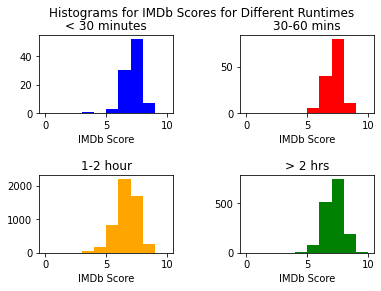

In [72]:
plt. clf()
# show graphs
display_runtime_graphs(movie_runtimes, axis_range=(0, 10))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


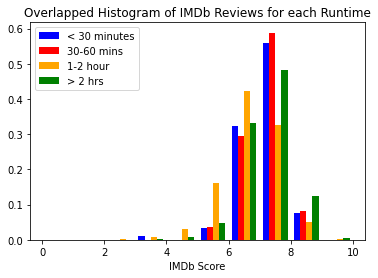

In [74]:
overlap_runtime_histograms(movie_runtimes, axis_range=(0, 10))

Let's find out how significant these results are. We can run t-tests on the different runtimes for movies (not on series, there are no different runtimes here)

In [73]:
# 4 t-tests, seeing if each runtime's imdb reviews are significantly different
# from the all runtime imdb reviews

all_reviews = movie_runtimes[0] + movie_runtimes[1] + movie_runtimes[2] + movie_runtimes[3]
ttests = [stats.ttest_ind(all_reviews, movie_runtimes[i]) for i in range(4)]

for i in range(4):
  print(f"For runtime {runtime_names[i]}, the t-value is {ttests[i][0]} and the p-value is {ttests[i][1]}")
print(ttests)

For runtime < 30 minutes, the t-value is -3.5442323147590495 and the p-value is 0.0003962936464760194
For runtime 30-60 mins, the t-value is -5.0358839611362045 and the p-value is 4.873121306265942e-07
For runtime 1-2 hour, the t-value is 7.4809975776502595 and the p-value is 7.880220859031242e-14
For runtime > 2 hrs, the t-value is -14.75265313573987 and the p-value is 1.169884586874494e-48
[Ttest_indResult(statistic=-3.5442323147590495, pvalue=0.0003962936464760194), Ttest_indResult(statistic=-5.0358839611362045, pvalue=4.873121306265942e-07), Ttest_indResult(statistic=7.4809975776502595, pvalue=7.880220859031242e-14), Ttest_indResult(statistic=-14.75265313573987, pvalue=1.169884586874494e-48)]


Time for something more complex. You know when you read a summary for a show/movie, and you know that it's just gonna be terrible? We could try to predict the IMDb score from the summary alone, using NLP techniques and a neural network.

In [75]:
# encode summary into a 512-dimensional vector, that preserves semantics and meaning
# save in np array
def preprocess_summary_prediction(dataframe, hub_layer):
  summary_column = dataframe["Summary"]
  imdb_column = dataframe["IMDb Score"]

  # a list of imdb reviews for each entry
  imdb_reviews = []

  # a 2d numpy array of the encoded summaries
  summary_data = []
  
  # process data to handle empty/bad rows
  for i in range(len(summary_column)):
    # print(i)
    summary_cell = summary_column[i]
    if not pd.isnull(summary_cell) and not pd.isnull(imdb_column[i]):
        try:
            # encoded_summary = hub_layer([summary_cell])
            # summary_data.append(encoded_summary)
            summary_data.append([summary_cell])
            imdb_reviews.append(imdb_column[i])
        except AttributeError:
            continue

  summary_data = np.array(summary_data)
  imdb_reviews = np.array(imdb_reviews)/10
  return summary_data, imdb_reviews

In [76]:
# preprocess data

embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
summary_data, imdb_reviews = preprocess_summary_prediction(movie_dataframe, hub_layer)

In [77]:
print(summary_data.shape)

(6998, 1)


In [78]:
model = tf.keras.Sequential()
# model.add()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='relu'))
model.summary()
config = model.get_config() # Returns pretty much every information about your model
print(config["layers"][0]["config"]["batch_input_shape"]) # returns a tuple of width, height and channels

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 16)                8208      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256,806,049
Trainable params: 256,806,049
Non-trainable params: 0
_________________________________________________________________
(None,)


In [79]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [80]:
print(imdb_reviews)
print(summary_data)
print(summary_data.shape)

[0.58 0.74 0.67 ... 0.62 0.73 0.78]
[['When nerdy Johanna moves to London, things get out of hand when she reinvents herself as a bad-mouthed music critic to save her poverty-stricken family.']
 ['After her ex-boyfriend cons her out of a large sum of money, a former bank employee tricks a scam artist into helping her swindle him in retaliation.']
 ['An unhappily married farm worker struggling to care for her children reflects on her lost youth and the scandalous moment that cost her true love.']
 ...
 ['Computer users across the globe log onto the virtual world of Second Life. But some users lives are dramatically consumed by this alternate reality.']
 ['In an idyllic port town on Australias west coast in the summer of 1969, carefree 16-year-old Willie enjoys hanging out with his pals and wooing a beautiful singer named Rosie -- until his mom ships him back to a Catholic boarding school in Perth.']
 ['In his third show, Daniël Arends argues that good deeds are a form of self interest, 

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    summary_data, imdb_reviews, test_size=.2, random_state=101)
# print(X_train.shape)
# print(X_test.shape)

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=.2, random_state=101)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')
y_validation = np.array(y_validation).astype('float32')

print(y_train.shape)
print(y_test.shape)
print(y_validation.shape)


(4478, 1)
(1120, 1)
(1400, 1)
(4478,)
(1400,)
(1120,)


Train the model that has been set up so far:

In [82]:
history = model.fit(x=X_train, y=y_train,
                    epochs=3,
                    validation_data=(X_validation, y_validation),
                    verbose=1)

Epoch 1/3
140/140 [==============================] - 355s 2s/step - loss: 0.2029 - accuracy: 0.0000e+00 - val_loss: 0.0077 - val_accuracy: 0.0000e+00
Epoch 2/3
140/140 [==============================] - 338s 2s/step - loss: 0.0079 - accuracy: 0.0000e+00 - val_loss: 0.0077 - val_accuracy: 0.0000e+00
Epoch 3/3
140/140 [==============================] - 343s 2s/step - loss: 0.0078 - accuracy: 0.0000e+00 - val_loss: 0.0077 - val_accuracy: 0.0000e+00


In [83]:
model.save("./")

OK. This model is kind of shit, ngl. Maybe a movie summary doesn't have much to do with its IMDb score.

The quality of a movie is not solely based upon its IMDb Score. IMDb is meant to represent what a general audience thinks of a movie. What about the critical reception of a movie? Rotten Tomatoes is typically a better gauge of how actual movie critics feel.

We should make a model to predict what the difference in IMDb score and Rotten Tomatoes score will be.

In [84]:
# since I'm lazy, just going to alter the dataframe and change IMDb score to IMDb - Rotten_Tomatoes/10
def get_altered_dataframe(dataframe):
  imdb = dataframe["IMDb Score"]
  rt = dataframe["Rotten Tomatoes Score"]
  altered_dataframe = dataframe.copy(deep=True)
  altered_dataframe["IMDb Score"] = imdb - rt/10
  return altered_dataframe

print(get_altered_dataframe(movie_dataframe)["IMDb Score"])


0      -2.1
1       NaN
2       NaN
3       NaN
4       4.2
       ... 
7005   -1.0
7006   -0.3
7007   -2.7
7008    NaN
7009    NaN
Name: IMDb Score, Length: 7010, dtype: float64


Re-running the genre multiple regression with the difference in reviews as the dependent variable.

In [85]:
altered_movie_dataframe = get_altered_dataframe(movie_dataframe)
params,sd_b,ts_b,p_values, genre_list = show_genre_regression_results(altered_movie_dataframe)
alpha = .05
for i in range(1, len(p_values)):
  if p_values[i] < alpha:
    print(f"Genre {genre_list[i-1]} is statistically significant at t-score of {ts_b[i]}. " + 
          f"It's presence corresponds to a {params[i]*10} change in predicted review difference.")

mean_squared_error :  0.040413250718050055
model R^2: 0.07562761780461102
Genre Drama is statistically significant at t-score of -8.674. It's presence corresponds to a -0.5820000000000001 change in predicted review difference.
Genre Fantasy is statistically significant at t-score of 4.055. It's presence corresponds to a 0.393 change in predicted review difference.
Genre Thriller is statistically significant at t-score of 6.768. It's presence corresponds to a 0.523 change in predicted review difference.
Genre Action is statistically significant at t-score of 7.375. It's presence corresponds to a 0.553 change in predicted review difference.
Genre Romance is statistically significant at t-score of 6.485. It's presence corresponds to a 0.481 change in predicted review difference.
Genre Family is statistically significant at t-score of 2.724. It's presence corresponds to a 0.325 change in predicted review difference.
Genre Documentary is statistically significant at t-score of -10.884. It's

Re-running the runtime analysis with review difference as dependent variable

For runtime < 30 minutes, average IMDb score is 0.0451612903225806, variance in IMDb score is 2.8818314255983357
For runtime 30-60 mins, average IMDb score is -0.8999999999999999, variance in IMDb score is 1.8717647058823528
For runtime 1-2 hour, average IMDb score is 0.22643735877479282, variance in IMDb score is 4.622602597569926
For runtime > 2 hrs, average IMDb score is 0.07271255060728743, variance in IMDb score is 2.9923161238505793

For runtime < 30 minutes, the t-value is 0.37033819561329445 and the p-value is 0.7111452831527045
For runtime 30-60 mins, the t-value is 3.0648084753598996 and the p-value is 0.00218901984378713
For runtime 1-2 hour, the t-value is -1.005586605202487 and the p-value is 0.3146407342134171
For runtime > 2 hrs, the t-value is 1.7333275660400875 and the p-value is 0.08308476999036125


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


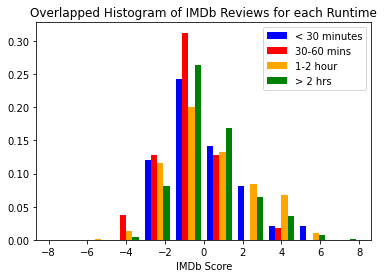

In [86]:
altered_movie_runtimes = runtime_stratification(altered_movie_dataframe)

all_reviews = altered_movie_runtimes[0] + altered_movie_runtimes[1] \
  + altered_movie_runtimes[2] + altered_movie_runtimes[3]
ttests = [stats.ttest_ind(all_reviews, altered_movie_runtimes[i]) for i in range(4)]
print()
runtime_names = ["< 30 minutes", "30-60 mins", "1-2 hour", "> 2 hrs"]
for i in range(4):
  print(f"For runtime {runtime_names[i]}, the t-value is {ttests[i][0]} and the p-value is {ttests[i][1]}")
# print(ttests)

overlap_runtime_histograms(altered_movie_runtimes, axis_range=(-8, 8))

In [87]:
model = tf.keras.Sequential()
# model.add()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='relu'))
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 16)                8208      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256,806,049
Trainable params: 256,806,049
Non-trainable params: 0
_________________________________________________________________


In [88]:
summary_data, imdb_reviews = preprocess_summary_prediction(altered_movie_dataframe, hub_layer)

X_train, X_test, y_train, y_test = train_test_split(
    summary_data, imdb_reviews, test_size=.2, random_state=101)
# print(X_train.shape)
# print(X_test.shape)

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=.2, random_state=101)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')
y_validation = np.array(y_validation).astype('float32')

print(y_train.shape)
print(y_test.shape)
print(y_validation.shape)


(3378, 1)
(845, 1)
(1056, 1)
(3378,)
(1056,)
(845,)


In [89]:
history = model.fit(x=X_train, y=y_train,
                    epochs=3,
                    validation_data=(X_validation, y_validation),
                    verbose=1)

Epoch 1/3
106/106 [==============================] - 265s 2s/step - loss: 0.0424 - accuracy: 0.0175 - val_loss: 0.0435 - val_accuracy: 0.0154
Epoch 2/3
106/106 [==============================] - 259s 2s/step - loss: 0.0424 - accuracy: 0.0175 - val_loss: 0.0435 - val_accuracy: 0.0154
Epoch 3/3
106/106 [==============================] - 256s 2s/step - loss: 0.0424 - accuracy: 0.0175 - val_loss: 0.0435 - val_accuracy: 0.0154
